In this notebook we will try to develop a model, that can detect high voltage breakdowns and filter them out.

As a first instance, we will use manually annotated data from _../Data_\__Annotated/Voltage_\__Breakdowns_, that will be loaded here and wenn will directly create a training and a validation set with an 80/20 split.

In [214]:
import pandas as pd
import numpy as np

In [215]:
import os

folder = '../Data_Annotated/Voltage_Breakdowns'
value_column = 'IP.NSRCGEN:SOURCEHTAQNI'
data_raw = []

for file in os.listdir(folder):
    if not file.endswith(".csv"):
        continue
    
    values = pd.read_csv(folder + '/' + file)[value_column].values
    label = 1 if file.startswith("breakdown") else 0
    data_raw.append((values, label))

Now we need to transfort the data so that we have an evenly sized window of 70 values (80-90 seconds of data). If the annotated data is shorter that this window size, we will pad it equally from the left and right. Otherwise we will subdevide it using a rolling window.

In [216]:
def create_padding(values, label, window_size):
    amount_to_pad = window_size - len(values)
    left = int(amount_to_pad / 2)
    right = amount_to_pad - left
    values = np.concatenate(([values[0]] * left, values), axis=None)
    values = np.concatenate((values, [values[-1]] * right), axis=None)
    return (values, label)

In [217]:
def create_subwindows(values, label, window_size):
    return [(values[i:i+window_size], label) for i in range(0, len(values)-window_size+1)]

In [260]:
window_size = 40

data = []
for value, label in data_raw:
    if len(value) >= window_size:
        data += create_subwindows(value, label, window_size)
    else:
        data += [create_padding(value, label, window_size)]

Shuffle the data and select 80% as training set.

In [261]:
import random

random.shuffle(data)
training_len = int(len(data) * 0.8)
training = data[:training_len]
validation = data[training_len:]

In [262]:
print("We have a training data set consisting of {} values and a validation data set consisting of {}.".format(len(training), len(validation)))

We have a training data set consisting of 1541 values and a validation data set consisting of 386.


As a first simple approach we will use the standard deviation as key indicator of a spark. The data suggests a threshold of 0.5.

In [271]:
std_threshold = 0.5

In [272]:
def classify_using_std_threshold(values, threshold):
    std = np.std(values)
    return int(std >= threshold)

In [273]:
def validate_method(validation_set, method, *params):
    false_positives = 0
    false_negatives = 0

    for vals, label in validation_set:
        res = method(vals, params)
        if res == 0 and label == 1:
            false_negatives += 1
        elif res == 1 and label == 0:
            false_positives += 1

    print("This method resulted in {} false positives and {} false negatives, yielding to an error of {}%".format(false_positives, false_negatives, round((false_positives+false_negatives)*100 / len(validation_set), 2)))

In [274]:
validate_method(validation, classify_using_std_threshold, std_threshold)

This method resulted in 0 false positives and 8 false negatives, yielding to an error of 2.07%


At least on the test set this method has a 98% accuraccy. This is not surprising as sparks look very different to usual data and can be caracterized through an exceptionally high cariance in a short amount of time. Live tests shall be performed to verify the model under normal circumstances.

For this we will look at data in the period _2018-11-10 23:00 to 2018-11-13 08:00_.

In [276]:
# %load ../ionsrcopt/load_data.py
import pandas as pd
import numpy as np

def read_data_from_csv(filename, cols_to_read, rows_to_read):
    """ Read a csv file into a DataFrame

    Parameters:
        filename (string): Filename
        cols_to_read (list of string): The column names to read, None if everything should be read
        rows_to_read (list of int): The rown numbers to read, None if everything should be read

    Returns:
        DataFrame
    """

    print("Loading data from csv file \'{}\'".format(filename))
    if cols_to_read is None:
        df = pd.read_csv(filename).fillna(method='ffill')
    else:
        df = pd.read_csv(filename, usecols=cols_to_read).fillna(method='ffill')

    if rows_to_read is None:
        return df
    else:
        return df.iloc[rows_to_read]

def convert_column(df, column, type):
    """ Converts the dtype of a column

    Parameters:
        df (DataFrame): The DataFrame containing the column
        column (string): The column name
        type (string): dtype the column should be converted to

    Returns:
        DataFrame: The altered DataFrame or the old one, if it did not contain the specified column
    """

    if column in df.columns:
        print("Converting column \'{}\' to \'{}\'".format(column, type))
        return df.astype({column:type})
    else:
        print("Column \'{}\' does not exist".format(column))
        return df

def convert_column_types(df):
    """ Convert all columns of a Dataframe of measurements to single precision values.

    Parameters:
        df (DataFrame): DataFrame to be altered

    Returns:
        DataFrame
    """

    print("Started type conversion of columns...")
    if 'Timestamp (UTC_TIME)' in df.columns:
        print("Converting column \'{}\' to \'{}\'".format('Timestamp (UTC_TIME)', 'datetime'))
        df['Timestamp (UTC_TIME)'] = pd.to_datetime(df['Timestamp (UTC_TIME)']) 
    df = convert_column(df, 'IP.NSRCGEN:BIASDISCAQNV', 'float32')
    df = convert_column(df, 'IP.NSRCGEN:GASSASAQN', 'float32')
    df = convert_column(df, 'IP.NSRCGEN:SOURCEHTAQNI', 'float32')
    df = convert_column(df, 'IP.SAIREM2:FORWARDPOWER', 'float32')
    df = convert_column(df, 'IP.SOLCEN.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'IP.SOLEXT.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'IP.SOLINJ.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'ITF.BCT15:CURRENT', 'float32')
    df = convert_column(df, 'ITF.BCT25:CURRENT', 'float32')
    df = convert_column(df, 'ITH.BCT41:CURRENT', 'float32')
    df = convert_column(df, 'ITL.BCT05:CURRENT', 'float32')
    return df


def set_BCT25_current_none(df, condition):
    df['ITF.BCT25:CURRENT'] = np.select([condition], [np.nan], [df['ITF.BCT25:CURRENT']])

def clean_data(df):
    """ Clean the data of measurements, that are outliers, e.g. spikes in the extraction current.

    Parameters:
        df (DataFrame): DataFrame containing the measurements.

    Returns:
        DataFrame: Cleaned data.
    """

    print("Filtering data...")
    #df.dropna(inplace=True)
    if 'ITF.BCT15:CURRENT' in df.columns:
        #df.drop(df[df['ITF.BCT15:CURRENT'] < 0].index, inplace=True)
        #set_BCT25_current_none(df, 'ITF.BCT15:CURRENT', lambda x: x < 0)  
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT15:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'ITF.BCT25:CURRENT' in df.columns:
        #df.drop(df[df['ITF.BCT25:CURRENT'] < 0].index, inplace=True)
        #set_BCT25_current_none(df, df['ITF.BCT25:CURRENT'] < 0)
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT25:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'ITH.BCT41:CURRENT' in df.columns:
        #df.drop(df[df['ITH.BCT41:CURRENT'] < 0].index, inplace=True)
        #set_BCT25_current_none(df, df['ITH.BCT41:CURRENT'] < 0)
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT41:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'ITL.BCT05:CURRENT' in df.columns:
        #df.drop(df[df['ITL.BCT05:CURRENT'] < 0].index, inplace=True)
        #set_BCT25_current_none(df, df['ITL.BCT05:CURRENT'] < 0)
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT05:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'IP.NSRCGEN:OVEN1AQNP' in df.columns:
        #df.drop(df[df['IP.NSRCGEN:OVEN1AQNP'] < 4.5].index, inplace=True)
        #set_BCT25_current_none(df, df['IP.NSRCGEN:OVEN1AQNP'] < 4.5)
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:OVEN1AQNP'].apply(lambda x: np.nan if x < 4.5 else x)
    if 'IP.SOLEXT.ACQUISITION:CURRENT' in df.columns:
        #df.drop(df[df['IP.SOLEXT.ACQUISITION:CURRENT'] < 1200].index, inplace=True)
        #set_BCT25_current_none(df, df['IP.SOLEXT.ACQUISITION:CURRENT'] < 1200)
        df['ITF.BCT25:CURRENT'] = df['IP.SOLEXT.ACQUISITION:CURRENT'].apply(lambda x: np.nan if x < 1200 else x)
    if 'IP.NSRCGEN:BIASDISCAQNV' in df.columns:
        #df.drop(df[df['IP.NSRCGEN:BIASDISCAQNV'] == 0].index, inplace=True)
        #set_BCT25_current_none(df, df['IP.NSRCGEN:BIASDISCAQNV'] == 0)
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:BIASDISCAQNV'].apply(lambda x: np.nan if x == 0 else x)
    if 'IP.SAIREM2:FORWARDPOWER' in df.columns:
        #df.drop(df[df['IP.SAIREM2:FORWARDPOWER'] < 500].index, inplace=True)
        #set_BCT25_current_none(df, df['IP.SAIREM2:FORWARDPOWER'] < 500)
        df['ITF.BCT25:CURRENT'] = df['IP.SAIREM2:FORWARDPOWER'].apply(lambda x: np.nan if x < 500 else x)
    if 'IP.NSRCGEN:SOURCEHTAQNI' in df.columns:
        #df.drop(df[df['IP.NSRCGEN:SOURCEHTAQNI'] > 2.5].index, inplace=True)
        #set_BCT25_current_none(df, df['IP.NSRCGEN:SOURCEHTAQNI'] > 2.5)
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:SOURCEHTAQNI'].apply(lambda x: np.nan if x > 2.5 else x)
    if 'IP.NSRCGEN:SOURCEHTAQNI' in df.columns:
        #df.drop(df[df['IP.NSRCGEN:SOURCEHTAQNI'] < 0.5].index, inplace=True)
        #set_BCT25_current_none(df, df['IP.NSRCGEN:SOURCEHTAQNI'] < 0.5)
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:SOURCEHTAQNI'].apply(lambda x: np.nan if x < 0.5 else x)
    
    return df

In [277]:
columns = ['Timestamp (UTC_TIME)', 'IP.NSRCGEN:SOURCEHTAQNI']
file = '../Data_Raw/Nov2018.csv'
df = read_data_from_csv(file, columns, None)
df = convert_column_types(df)

Loading data from csv file '../Data_Raw/Nov2018.csv'
Started type conversion of columns...
Converting column 'Timestamp (UTC_TIME)' to 'datetime'
Column 'IP.NSRCGEN:BIASDISCAQNV' does not exist
Column 'IP.NSRCGEN:GASSASAQN' does not exist
Converting column 'IP.NSRCGEN:SOURCEHTAQNI' to 'float32'
Column 'IP.SAIREM2:FORWARDPOWER' does not exist
Column 'IP.SOLCEN.ACQUISITION:CURRENT' does not exist
Column 'IP.SOLEXT.ACQUISITION:CURRENT' does not exist
Column 'IP.SOLINJ.ACQUISITION:CURRENT' does not exist
Column 'ITF.BCT15:CURRENT' does not exist
Column 'ITF.BCT25:CURRENT' does not exist
Column 'ITH.BCT41:CURRENT' does not exist
Column 'ITL.BCT05:CURRENT' does not exist


In [278]:
start_date = '2018-11-10 23:00'
end_date = '2018-11-13 08:00'
df = df.loc[(df['Timestamp (UTC_TIME)'] >= start_date) & (df['Timestamp (UTC_TIME)'] <= end_date)].copy()

After loading the data we move a rolling window over it and apply the beforementioned method. Whenever a spark is detected, all corresponding datapoints get marked as beeing in a high voltage breakdown.

In [279]:
min_index = df.iloc[0].name

df['IS_BREAKDOWN'] = 0
values = df['IP.NSRCGEN:SOURCEHTAQNI'].values

for i in range(len(values) - window_size):
    is_breakdown = classify_using_std_threshold(values[i:i+window_size], std_threshold)
    if is_breakdown:
        df.loc[(df.index >= min_index + i) & (df.index < min_index + i + window_size), 'IS_BREAKDOWN'] = 1

Below is a vizualization of the results hat looks very satisfying.

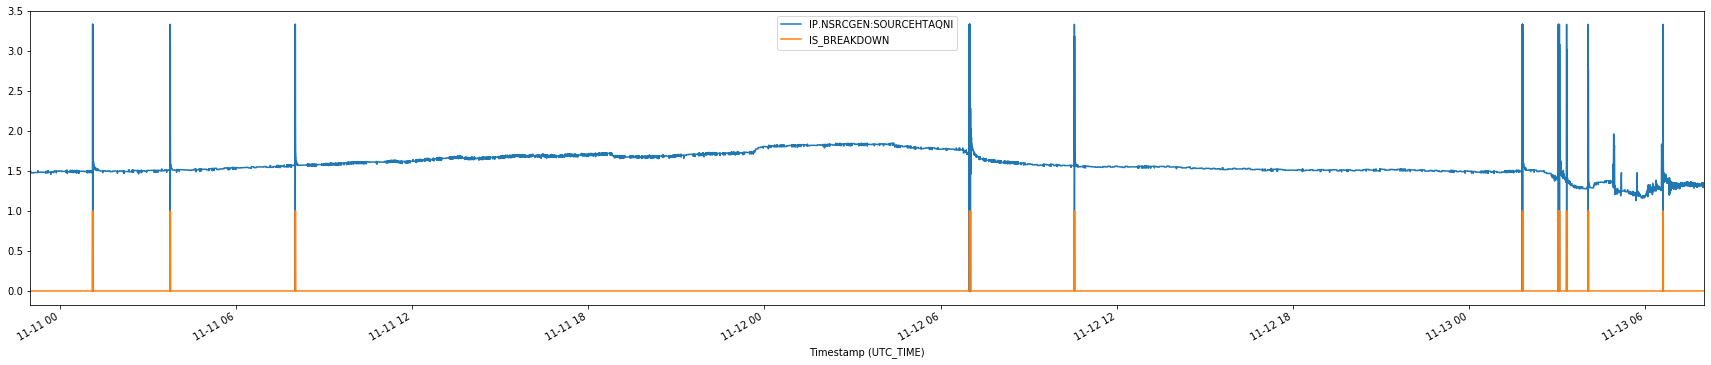

In [288]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,6)

df.plot(x='Timestamp (UTC_TIME)')

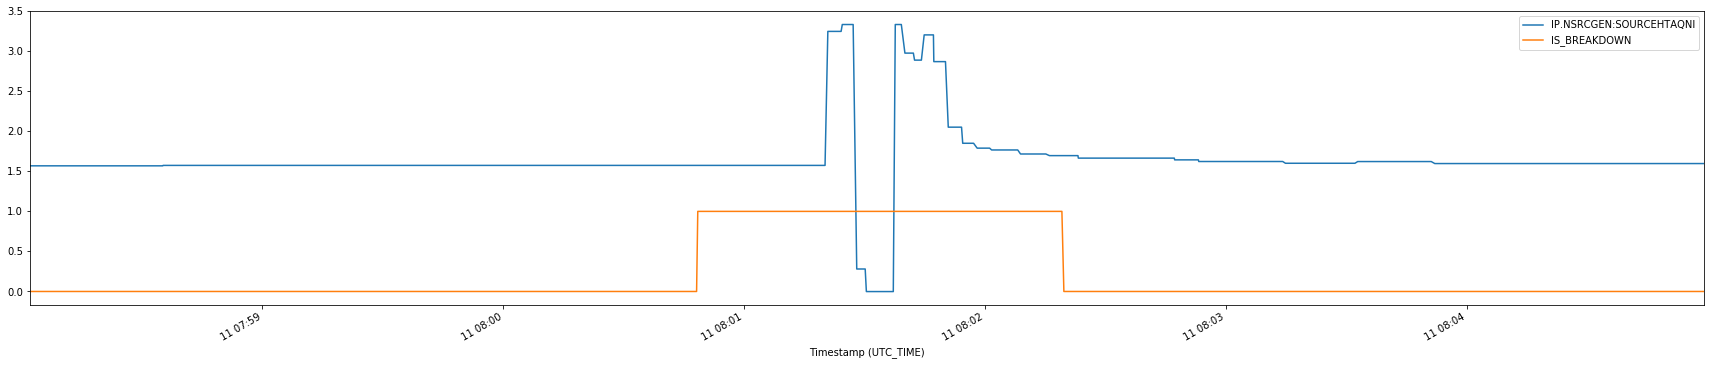

In [289]:
df.loc[(df['Timestamp (UTC_TIME)'] >= '2018-11-11 07:58') & (df['Timestamp (UTC_TIME)'] <= '2018-11-11 08:05')].plot(x='Timestamp (UTC_TIME)')

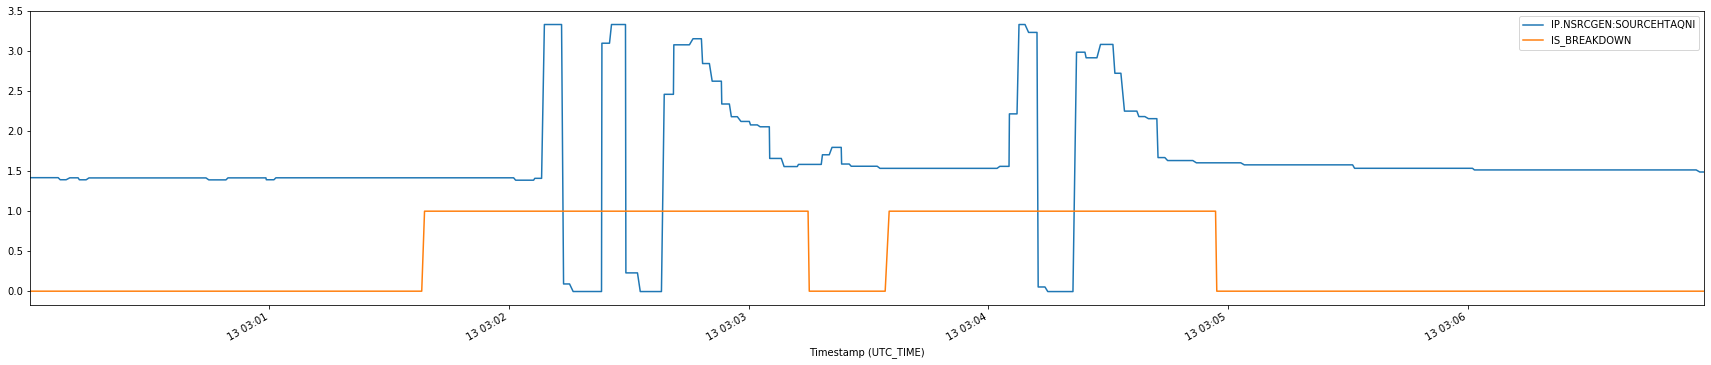

In [286]:
df.loc[(df['Timestamp (UTC_TIME)'] >= '2018-11-13 03:00') & (df['Timestamp (UTC_TIME)'] <= '2018-11-13 03:07')].plot(x='Timestamp (UTC_TIME)')